In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
df = pd.read_csv("../resources/curr_datausage.csv", parse_dates=["dtime"])
df.head()

,unit_id,dtime,sk_tx_bytes,sk_rx_bytes,cust_wired_tx_bytes,cust_wired_rx_bytes,cust_wifi_tx_bytes,cust_wifi_rx_bytes
0,386,2023-01-01 06:32:00,0,61288,42114358,2190548237,0,3225217
1,386,2023-01-01 07:32:02,0,77942,36364678,1781312604,0,2878273
2,386,2023-01-01 08:32:03,1593,59292,31497966,914522306,0,2649831
3,386,2023-01-01 09:32:05,0,61601,37000182,1609290026,0,2889108
4,386,2023-01-01 10:32:07,2552,103223,33011116,1499945826,0,2771261


In [9]:
df["cust_total_tx"] = df["cust_wired_tx_bytes"] + df["cust_wifi_tx_bytes"]
df["cust_total_rx"] = df["cust_wired_rx_bytes"] + df["cust_wifi_rx_bytes"]
df["cust_total_bytes"] = df["cust_total_tx"] + df["cust_total_rx"]

In [10]:
df = df.sort_values(["unit_id", "dtime"])
df["delta_tx"] = df.groupby("unit_id")["cust_total_tx"].diff()
df["delta_rx"] = df.groupby("unit_id")["cust_total_rx"].diff()

In [11]:
df["tx_bps"] = df["delta_tx"] * 8 / 3600
df["rx_bps"] = df["delta_rx"] * 8 / 3600

In [12]:
df = df[(df["delta_tx"] >= 0) & (df["delta_rx"] >= 0)]
df.reset_index(drop=True, inplace=True)


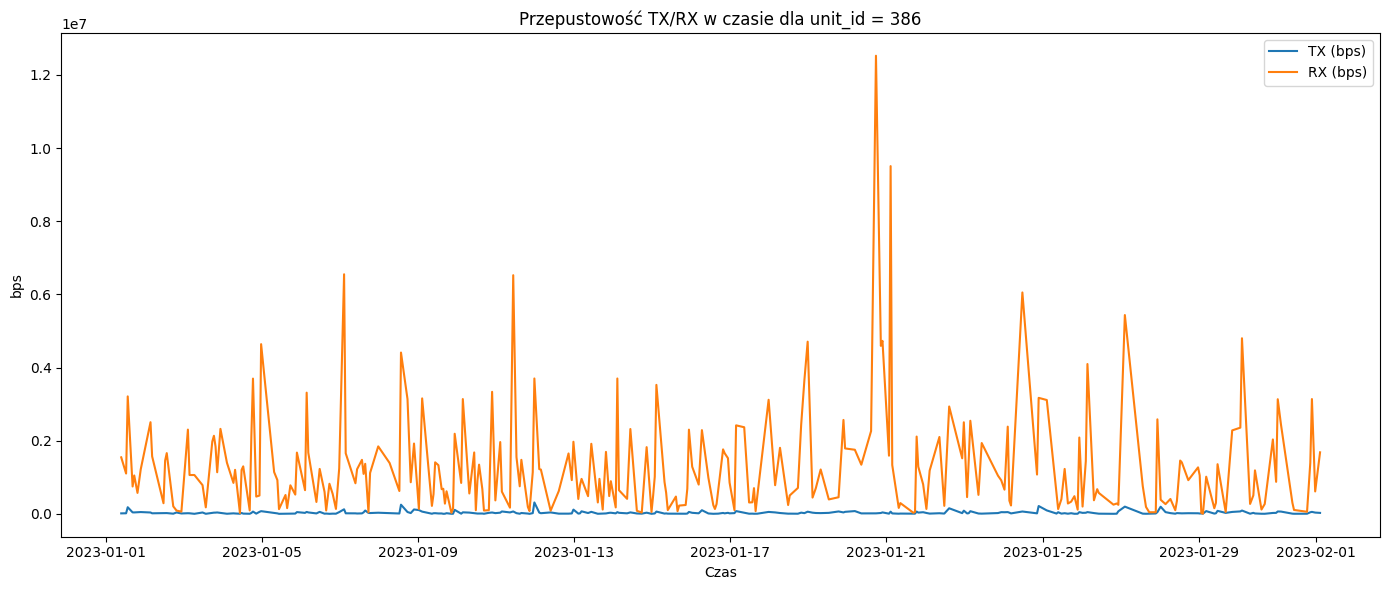

In [14]:
unit_df = df[df["unit_id"] == 386]

plt.figure(figsize=(14, 6))
plt.plot(unit_df["dtime"], unit_df["tx_bps"], label="TX (bps)")
plt.plot(unit_df["dtime"], unit_df["rx_bps"], label="RX (bps)")
plt.title("Przepustowość TX/RX w czasie dla unit_id = 386")
plt.xlabel("Czas")
plt.ylabel("bps")
plt.legend()
plt.tight_layout()
plt.show()


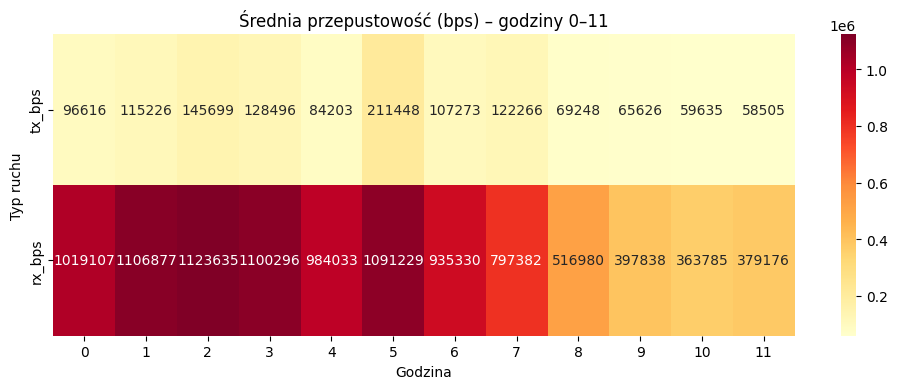

In [17]:
df["hour"] = df["dtime"].dt.hour
morning = df[df["hour"] < 12].groupby("hour")[["tx_bps", "rx_bps"]].mean().T

plt.figure(figsize=(10, 4))
sns.heatmap(morning, annot=True, fmt=".0f", cmap="YlOrRd")
plt.title("Średnia przepustowość (bps) – godziny 0–11")
plt.xlabel("Godzina")
plt.ylabel("Typ ruchu")
plt.tight_layout()
plt.show()



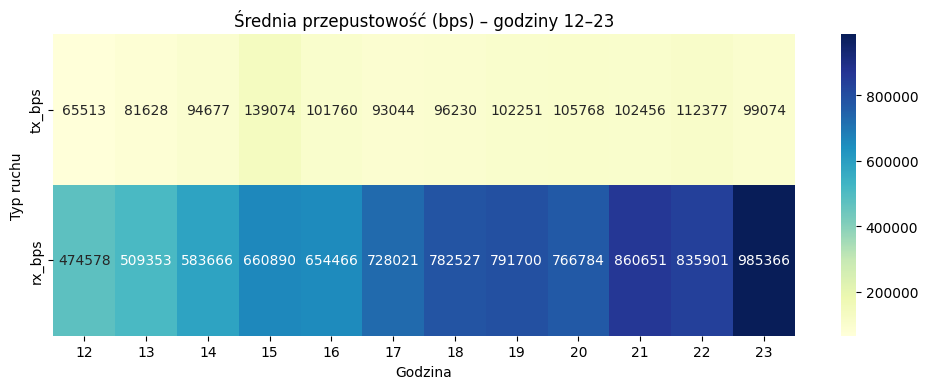

In [18]:
afternoon = df[df["hour"] >= 12].groupby("hour")[["tx_bps", "rx_bps"]].mean().T

plt.figure(figsize=(10, 4))
sns.heatmap(afternoon, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Średnia przepustowość (bps) – godziny 12–23")
plt.xlabel("Godzina")
plt.ylabel("Typ ruchu")
plt.tight_layout()
plt.show()


C:\Users\wiora\AppData\Local\Temp\ipykernel_31664\2180614708.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=means.index, y=means.values, palette="muted")


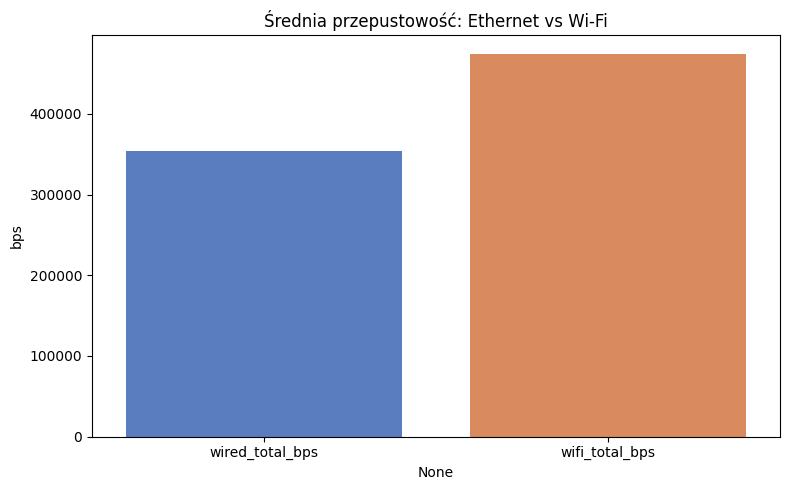

In [16]:
df["wired_total_bps"] = (df["cust_wired_tx_bytes"] + df["cust_wired_rx_bytes"]).diff() * 8 / 3600
df["wifi_total_bps"] = (df["cust_wifi_tx_bytes"] + df["cust_wifi_rx_bytes"]).diff() * 8 / 3600

df = df[(df["wired_total_bps"] >= 0) & (df["wifi_total_bps"] >= 0)]

means = df[["wired_total_bps", "wifi_total_bps"]].mean()

plt.figure(figsize=(8, 5))
sns.barplot(x=means.index, y=means.values, palette="muted")
plt.title("Średnia przepustowość: Ethernet vs Wi-Fi")
plt.ylabel("bps")
plt.tight_layout()
plt.show()


In [19]:
df["sk_total_bytes"] = df["sk_tx_bytes"] + df["sk_rx_bytes"]
df["sk_total_diff"] = df.groupby("unit_id")["sk_total_bytes"].diff()

df_sk = df[df["sk_total_diff"] > 0].copy()


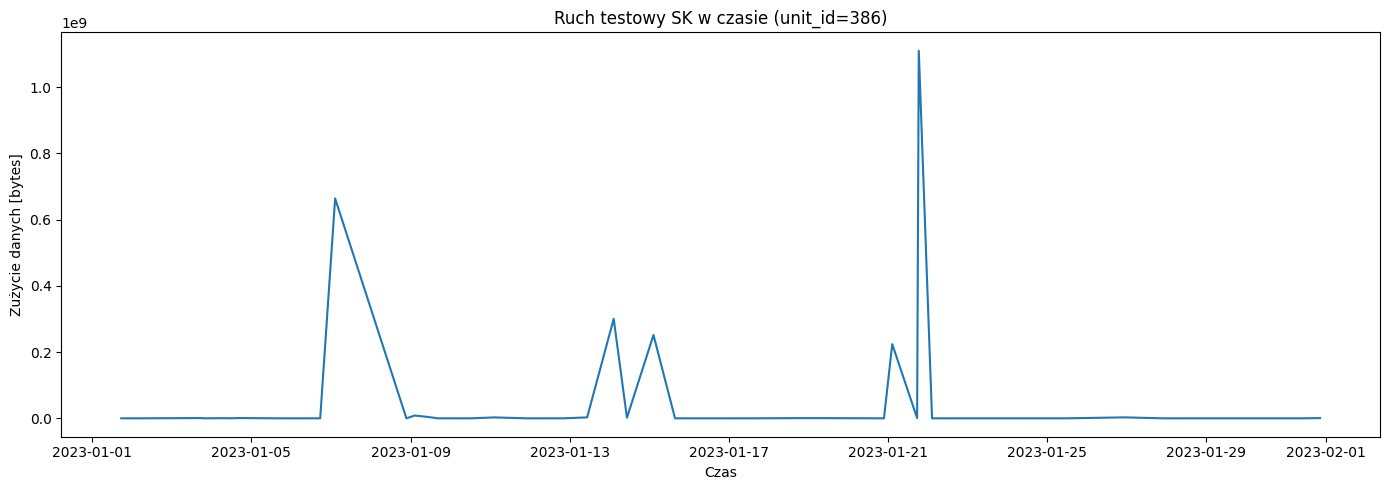

In [20]:
unit_sk = df_sk[df_sk["unit_id"] == 386]

plt.figure(figsize=(14, 5))
plt.plot(unit_sk["dtime"], unit_sk["sk_total_diff"])
plt.title("Ruch testowy SK w czasie (unit_id=386)")
plt.ylabel("Zużycie danych [bytes]")
plt.xlabel("Czas")
plt.tight_layout()
plt.show()


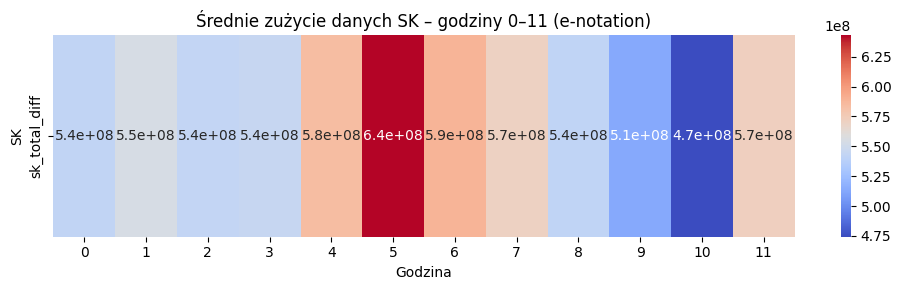

In [23]:
df_sk["hour"] = df_sk["dtime"].dt.hour
sk_morning = df_sk[df_sk["hour"] < 12].groupby("hour")["sk_total_diff"].mean()

plt.figure(figsize=(10, 3))
sns.heatmap(sk_morning.to_frame().T, annot=True, fmt=".1e", cmap="coolwarm")
plt.title("Średnie zużycie danych SK – godziny 0–11 (e-notation)")
plt.xlabel("Godzina")
plt.ylabel("SK")
plt.tight_layout()
plt.show()


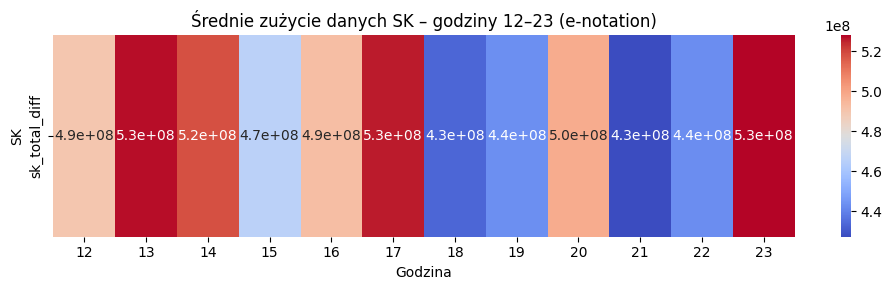

In [24]:
sk_afternoon = df_sk[df_sk["hour"] >= 12].groupby("hour")["sk_total_diff"].mean()

plt.figure(figsize=(10, 3))
sns.heatmap(sk_afternoon.to_frame().T, annot=True, fmt=".1e", cmap="coolwarm")
plt.title("Średnie zużycie danych SK – godziny 12–23 (e-notation)")
plt.xlabel("Godzina")
plt.ylabel("SK")
plt.tight_layout()
plt.show()


In [25]:
df["hour"] = df["dtime"].dt.hour
df["cust_total_bytes_diff"] = df.groupby("unit_id")["cust_total_bytes"].diff()
df["sk_total_bytes"] = df["sk_tx_bytes"] + df["sk_rx_bytes"]
df["sk_total_diff"] = df.groupby("unit_id")["sk_total_bytes"].diff()

compare_df = df.groupby("hour")[["cust_total_bytes_diff", "sk_total_diff"]].mean()
compare_df = compare_df.dropna()


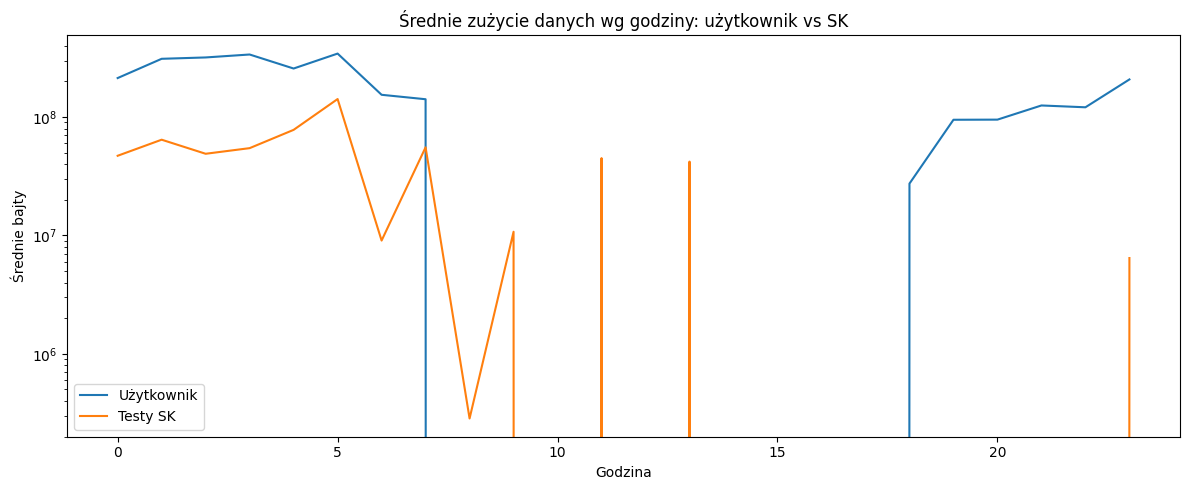

In [26]:
plt.figure(figsize=(12, 5))
plt.plot(compare_df.index, compare_df["cust_total_bytes_diff"], label="Użytkownik")
plt.plot(compare_df.index, compare_df["sk_total_diff"], label="Testy SK")
plt.title("Średnie zużycie danych wg godziny: użytkownik vs SK")
plt.xlabel("Godzina")
plt.ylabel("Średnie bajty")
plt.legend()
plt.yscale("log") 
plt.tight_layout()
plt.show()


In [27]:
correlation = compare_df.corr().loc["cust_total_bytes_diff", "sk_total_diff"]
print(f"Korelacja między ruchem użytkownika a testami SK: {correlation:.2f}")


Korelacja między ruchem użytkownika a testami SK: 0.37
